In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
train_data = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
test_data = pd.read_csv ('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')


In [5]:
#test_data.sample(6)
train_data.sample(6)
train_data.shape

(40479, 2)

In [6]:
train_data.head(4)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary


In [7]:
labels = [ ]
#train_classes.tags.value_counts()
train_data.tags.values

for items in train_data.tags.values:
    split = items.split(' ')
    for label in split:
      if label not in labels:
        labels.append(label)

len(labels)
labels

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [8]:
np.array(labels)

array(['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down'], dtype='<U17')

In [9]:
train_data.values

array([['train_0', 'haze primary'],
       ['train_1', 'agriculture clear primary water'],
       ['train_2', 'clear primary'],
       ...,
       ['train_40476', 'agriculture clear primary'],
       ['train_40477', 'agriculture clear primary road'],
       ['train_40478', 'agriculture cultivation partly_cloudy primary']],
      dtype=object)

In [10]:
dic = {}
for x, y in enumerate(labels):
    dic[y] = x
dic

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [11]:
## splitting the image data into training and testing set

x_train = []
y_train = []

for image,tags in tqdm(train_data.values,miniters=1000):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(image))
    targets = np.zeros(17)
    for tag in tags.split(' '):
        targets[dic[tag]] = 1
    x_train.append(cv2.resize(img, (32,32)))
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [09:13<00:00, 73.14it/s]


(40479, 32, 32, 3)
(40479, 17)


In [12]:
#x_train
fig_split = round(x_train.shape[0]*0.80,-3) ## outputs 32000
fig_split =int(fig_split)
#type(fig_split)


x_train, x_test, y_train, y_test = x_train[:32000], x_train[32000:], y_train[:32000], y_train[32000:]

y_test.shape

(8479, 17)

In [13]:
## buidling the tensorflow model with 3 layers

model = Sequential()
# layer 1
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#layer 2
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#layer 3
model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train,batch_size=128,epochs=10,verbose=1)

Epoch 1/10
250/250 [==============================] - 124s 489ms/step - loss: 0.2160 - accuracy: 0.8489
Epoch 2/10
250/250 [==============================] - 122s 488ms/step - loss: 0.1634 - accuracy: 0.8354
Epoch 3/10
250/250 [==============================] - 122s 489ms/step - loss: 0.1468 - accuracy: 0.8101
Epoch 4/10
250/250 [==============================] - 122s 487ms/step - loss: 0.1387 - accuracy: 0.8040
Epoch 5/10
250/250 [==============================] - 122s 487ms/step - loss: 0.1328 - accuracy: 0.7999
Epoch 6/10
250/250 [==============================] - 122s 487ms/step - loss: 0.1272 - accuracy: 0.8093
Epoch 7/10
250/250 [==============================] - 121s 485ms/step - loss: 0.1209 - accuracy: 0.8090
Epoch 8/10
250/250 [==============================] - 121s 486ms/step - loss: 0.1169 - accuracy: 0.8063
Epoch 9/10
250/250 [==============================] - 121s 483ms/step - loss: 0.1122 - accuracy: 0.8078
Epoch 10/10
250/250 [==============================] - 121s 483m

In [14]:
y_pred = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average = 'samples'))

67/67 [==============================] - 8s 111ms/step
0.8913662519745441


In [15]:
history.history

{'loss': [0.21600423753261566,
  0.16335429251194,
  0.1467566192150116,
  0.1386824995279312,
  0.13283801078796387,
  0.12717629969120026,
  0.12090487778186798,
  0.11691813915967941,
  0.11218862235546112,
  0.10778778791427612],
 'accuracy': [0.8489062786102295,
  0.8353750109672546,
  0.8100625276565552,
  0.8040000200271606,
  0.799875020980835,
  0.8092812299728394,
  0.8090000152587891,
  0.8063437342643738,
  0.8078437447547913,
  0.8046562671661377]}

In [ ]:
## using additional test data to test the accuracy of our model

x_add_test = []
img_title_add = []
x_test2 =[]
img_title = []
for images in tqdm(listdir('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional')):
    print(images)
    img = cv2.imread('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(images.split('.')[0]))
    x_add_test.append(cv2.resize(img,(32,32)))
    img_title_add.append(images.split('.')[0])

for x in tqdm(listdir('/kaggle/input/planets-dataset/planet/planet/test-jpg')):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img_name))
    x_test2.append(cv2.resize(img, (32,32)))
    img_title.append(img_name)

#len(x_add_test)    

 

In [103]:
len(x_add_test)
x_add_test = np.array(x_add_test,float)/255 #normalization
x_test2 = np.array(x_test2,float)/255  #normalization
print(x_add_test.shape,x_test2.shape)

(20522, 32, 32, 3) (40669, 32, 32, 3)


In [104]:

predict_add_test = model.predict(x_add_test, batch_size =128)
predict_test2= model.predict(x_test2, batch_size =128)
print(predict_add_test.shape,predict_test2.shape)

#model.evaluate(x_test,y_test)


318/318 [==============================] - 36s 113ms/step
(20522, 17) (40669, 17)


In [110]:
model.evaluate(x_add_test,predict_add_test,batch_size =128,verbose =1)
model.evaluate(x_test2,predict_test2,batch_size =128,verbose =1)
model.summary()

318/318 [==============================] - 36s 114ms/step - loss: 0.1060 - accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  

In [112]:
## Getting tags for additional test data

image2 = []
tags2 = []
for i, img in enumerate(img_title_add):
    image2.append(img)
    tags2.append(' '.join(np.array(labels)[predict_add_test[i] > 0.2]))
df2 = pd.DataFrame()
df2['image_name'] = image2
df2['tags'] = tags2
df2


## Getting tags for test data

image1= []
tags1 = []
for i, img in enumerate(img_title):
    image1.append(img)
    tags1.append(' '.join(np.array(labels)[predict_test2[i] > 0.2]))
df1 = pd.DataFrame()
df1['image_name'] = image1
df1['tags'] = tags1
df1


df3 = pd.concat([df1,df2])
df3.shape

(61191, 2)

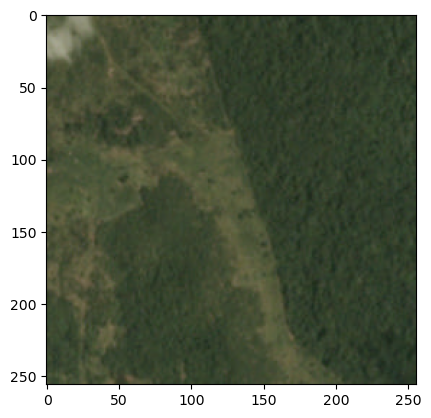

In [96]:
## checking random images 

img_test = 'file_8496.jpg'
path = '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/{}'.format(img_test)
img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))



In [135]:
df3.to_csv('forKaggleSubmission.csv')
df4 = pd.read_csv('/kaggle/working/forKaggleSubmission.csv')
#df4.columns

df4.drop('Unnamed: 0',axis =1,inplace =True)
df4.to_csv('kagglesubmission.csv')
pd.read_csv('/kaggle/working/kagglesubmission.csv')

,Unnamed: 0,image_name,tags
0,0,test_39140,primary agriculture clear cultivation
1,1,test_4849,primary clear
2,2,test_18979,primary agriculture clear water habitation roa...
3,3,test_24790,primary agriculture clear road
4,4,test_30624,primary clear
...,...,...,...
61186,61186,file_6101,primary partly_cloudy
61187,61187,file_7113,primary clear
61188,61188,file_9271,primary agriculture clear water road
61189,61189,file_13908,primary agriculture clear water habitation roa...


In [115]:
df3

#pd.read_csv('/kaggle/working/final_submission.csv')

,image_name,tags
0,test_39140,primary agriculture clear cultivation
1,test_4849,primary clear
2,test_18979,primary agriculture clear water habitation roa...
3,test_24790,primary agriculture clear road
4,test_30624,primary clear
...,...,...
20517,file_6101,primary partly_cloudy
20518,file_7113,primary clear
20519,file_9271,primary agriculture clear water road
20520,file_13908,primary agriculture clear water habitation roa...
